# Document Similarity Graph Generation

## TODO
 * Build graph based on similarities
 * Output graph in dot format and visualize with graphviz
 * Clean up the notebook (will look like crap at this point)
 * Explore using simhashing to speed up the similarity lookups

In [113]:
from graphviz import Digraph, Graph

import numpy as np
from sklearn.feature_extraction.text import *
from sklearn.metrics.pairwise import cosine_similarity

import datetime
import io
import os

In [195]:
DATA_ROOT = os.path.join(os.path.expanduser('~'), 'data')
FULLTEXT_FOLDER = os.path.join(DATA_ROOT, 'url-header-html-txt')
# Randomly selected topic to work with. This one has about 300 documents.
TOPIC = 20986
# This topic has fewer documents => easier visualization.
TOPIC = 20022

In [196]:
folder = os.path.join(FULLTEXT_FOLDER, str(TOPIC))
print(folder)

/Users/andrei/data/url-header-html-txt/20022


In [197]:
# Grab every file from the topic, and only look at those whose
# names end in '.txt', i.e. the HTML text with all HTML tags stripped
# away.
file_names = [f for f in os.listdir(folder) 
                 if os.path.isfile(os.path.join(folder, f))
                 and f.endswith(".txt")]
print("We have %d files." % len(file_names))

We have 139 files.


In [198]:
def read_file(name):
    encoding = 'ISO-8859-1'
    with io.open(name, 'r', encoding=encoding) as file:
        return file.read()
    
    
# A map of file names (IDs) to their contents.
doc_id_to_doc = {}
corpus = []

for f in file_names:
    doc_id = f[:f.rfind('.')]
    text = read_file(os.path.join(folder, f))
    doc_id_to_doc[doc_id] = text
    corpus.append((doc_id, text))

In [199]:
vectorizer = TfidfVectorizer(min_df=1)
# Make sure we just pass document texts, and not (doc_id, text) tuples to
# the tf-idf vectorizer.
term_doc_matrix = vectorizer.fit_transform([text for doc_id, text in corpus])

In [200]:
# TODO(andrei) This kernel is a popular choice for computing the
# similarity of documents represented as tf-idf vectors.
# cosine_similarity accepts scipy.sparse matrices. (Note that the tf-idf
# functionality in sklearn.feature_extraction.text can produce normalized
# vectors, in which case cosine_similarity is equivalent to linear_kernel,
# only slower.)

In [201]:
# Automagically computes ALL pairwise cosine similarities between
# the documents in our corpus.
similarities = cosine_similarity(term_doc_matrix)

In [202]:
class DocumentEdge(object):
    """ Represents an edge in the document similarity graph.
    
    """
    def __init__(self, from_document_id, to_document_id, similarity):
        self.from_document_id = from_document_id
        self.to_document_id = to_document_id
        self.similarity = similarity


class DocumentNode(object):
    """ Represents a node (a document) in the document similarity graph.
    
    Attributes:
        topic_id: The int ID of the topic to which the document belongs.
        document_id: The ID of the document, without any file extension.
        document_name: The full name of the document (usually its ID, plus
            its extension).
        neighbors: A list of 'DocumentEdge' objects, representing this
            node's neighbors.
    """
    def __init__(self, topic_id, document_id, document_name, neighbors):
        self.topic_id = topic_id
        self.document_id = document_id
        self.document_name = document_name
        self.neighbors = neighbors

In [203]:
sim_threshold = 0.90
file_names_np = np.array(file_names)

graph = []

topic = TOPIC
total_edges = 0

# Whether we should print out larger clusters to facilitate manual inspection.
print_large_clusters = False

for row_index in range(len(similarities)):
    sims = similarities[row_index]
    doc_id, document = corpus[row_index]
    
    mask = sims > sim_threshold
    # Make sure we don't have an edge to ourselves, since we're always
    # 100% similar to ourselves.
#     mask[row_index] = False
    relevant_sims = sims[mask]
    relevant_docs = file_names_np[mask]
    
    neighbors = []
    for sim, other_doc_name in zip(relevant_sims, relevant_docs):
        other_doc_id = other_doc_name[:other_doc_name.rfind('.')]
        neighbors.append(DocumentEdge(doc_id, other_doc_id, sim))
        
    node = DocumentNode(topic, doc_id, file_names_np[row_index], neighbors)
    total_edges += len(neighbors)
    graph.append(node)
    
    # Sanity check: every document must be 100% similar to itself.
    assert np.allclose(sims[row_index], 1.0)
    
    # Explicitly print out larger clusters to facilitate manual inspection.
    if print_large_clusters and len(relevant_sims) > 15:
        print("Document %s has some similar friends!" % doc_id)
        print(list(zip(relevant_sims, relevant_docs)))
        
# Note: this treats similarity edges as directed, even though they aren't.
# Moreover, even though they should be, the edges aren't always 100% "undirected",
# since (perhaps due to rounding errors) some similarity edges end up being only
# one-way.
print("Built graph with %d total edges." % (total_edges / 2))

Built graph with 149 total edges.


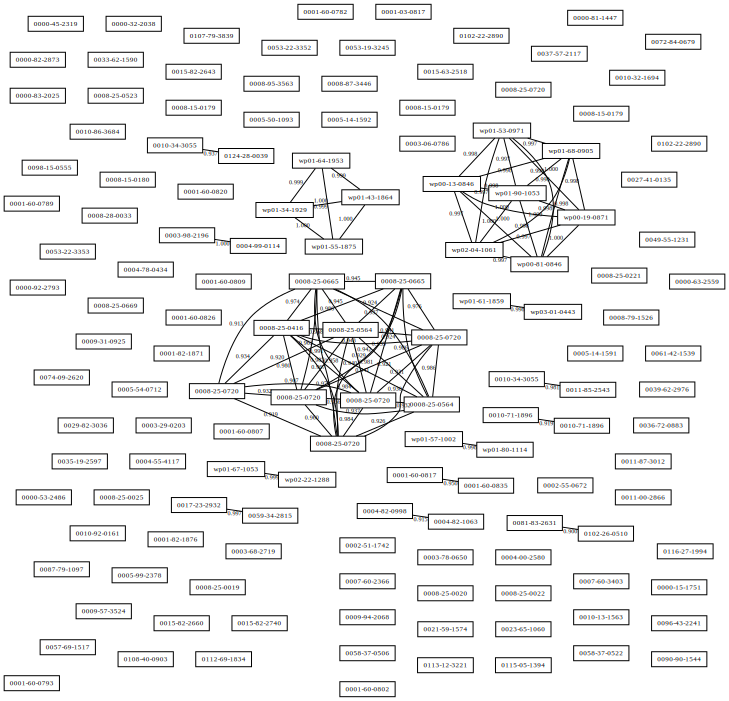

In [251]:
dot = Graph(comment='Similarity graph', engine='neato')
dot.body.append('size="18,18"')
dot.body.append('splines=true;')
dot.body.append('overlap=scalexy;')
dot.body.append('nodesep=25.0;')

SHORT_NAME_OFFSET = 7

for node in graph:
    name = node.document_id
    short_name = name[name.rfind('-') - SHORT_NAME_OFFSET : name.rfind('.')]
    full_path = "file://" + os.path.join(folder, name + ".txt")
    dot.node(name, label=short_name, color=None, fontsize='7', shape='box', height='0', width='0',
             tooltip=name, href=full_path)
    

for node in graph:
    for neighbor in node.neighbors:
        if neighbor.to_document_id > neighbor.from_document_id:
            label = "%.3f" % neighbor.similarity
            dot.edge(
                neighbor.from_document_id, neighbor.to_document_id,
                label=label,
                fontsize='6')
            
dot